In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06f_mixup.ipynb"
_nb_title = "Data Augmentation: Mixup"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Data+Augmentation%3A+Mixup&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F06_preprocessing%2F06f_mixup.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06f_mixup.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06f_mixup.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/06_preprocessing/06f_mixup.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# データ拡張: MixUp 

このノートブックでは、モデルの汎化性能と精度を向上させるためにデータ拡張を実行します

空間的な変換と色の拡張に加えて  
[06d_colorConstraintion.ipynb](./06d_colorConstraintion.ipynb)に、MixUpを実行するレイヤーを追加します(https://arxiv.org/abs/1710.09412)

## 実行環境
このノートブックは、TPUまたはGPUで実行するように設定されています。GPUでは実行に時間がかかるため、特にTPUでの実行を推奨しています。

Vertex AI WorkbenchやColabでTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [ ]:
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## 前処理関数 `_Preprocessor`  

このクラスには、学習と推論の両方で明示的に適用する必要がある前処理関数を含めます。

In [2]:
# Helper functions
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, tf.one_hot(label_int, len(CLASS_NAMES))
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

## 色の拡張のためのカスタムレイヤー  

この層では、学習中に画像のコントラストと明るさをランダムに変更します。  
推論中は、画像は変更されずにそのまま通過します。

In [4]:
class RandomColorDistortion(tf.keras.layers.Layer):
    def __init__(self, contrast_range=[0.5, 1.5], 
                 brightness_delta=[-0.2, 0.2], **kwargs):
        super(RandomColorDistortion, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.brightness_delta = brightness_delta
    
    def call(self, images, training=None):
        if not training:
            return images
        
        contrast = np.random.uniform(
            self.contrast_range[0], self.contrast_range[1])
        brightness = np.random.uniform(
            self.brightness_delta[0], self.brightness_delta[1])
        
        images = tf.image.adjust_contrast(images, contrast)
        images = tf.image.adjust_brightness(images, brightness)
        images = tf.clip_by_value(images, 0, 1)
        return images

2022-07-11 21:22:05.805627: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 130, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657574525.802263507","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 130, Output num: 0","grpc_status":3}


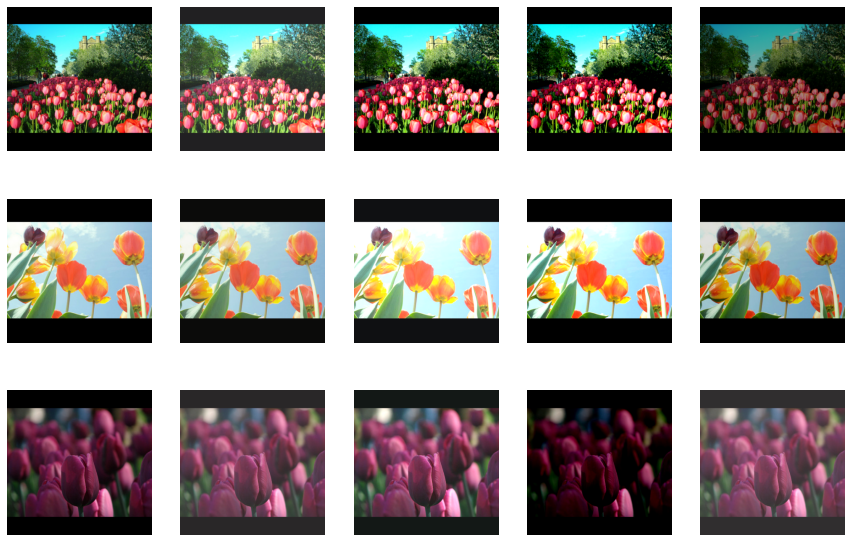

In [5]:
layer=RandomColorDistortion()
trainds = create_preproc_dataset('gs://practical-ml-vision-book/flowers_tfr/train-*')
f, ax = plt.subplots(3, 5, figsize=(15,10))
for rowno, (img, label) in enumerate(trainds.take(3)):
    ax[rowno, 0].imshow((img.numpy()));
    ax[rowno, 0].axis('off')
    for idx in range(1, 5):
        aug = layer(img, training=True)
        ax[rowno, idx].imshow((aug.numpy()));
        ax[rowno, idx].axis('off')

## Mixupのカスタム前処理機能  

[Mixup](https://arxiv.org/abs/1710.09412)の背後にある考え方は、トレーニング画像のペアを線形補間し、対応するラベルの間を補間したラベル値をラベルとして割り当てるというものです。

Kerasの層は画像のみを受け取るたり、ラベルは受け取らないため、KerasのCustom Layerでは実行できません。  

以下の関数は、`(img, label)`タプルのバッチを取得し、それらを混ぜ合わせて合成画像を作成します。  
これを.batch()の後に.map()に渡します。

In [11]:
MIXUP_FRAC=0.4
def augment_mixup(img, label):
    def _interpolate(b1, b2, t):
        return t*b1 + (1-t)*b2

    # parameters
    n = np.rint(MIXUP_FRAC * len(img)).astype(np.int32)
    t = np.round(np.random.uniform(0.5, 0.8), 2)
    
    # change the first frac of the result
    img1, label1 = img[:n], label[:n]
    img2, label2 = img[1:n+1], label[1:n+1] # offset by one
    interp_img = _interpolate(img1, img2, t)
    interp_label = _interpolate(label1, label2, t)
       
    # change only the first n
    img = tf.concat([interp_img, img[n:]], axis=0)
    label = tf.concat([interp_label, label[n:]], axis=0)
    return img, label

(5, 448, 448, 3)
(5, 5)


2022-07-11 21:26:22.838446: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 740, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657574782.838330494","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 740, Output num: 0","grpc_status":3}


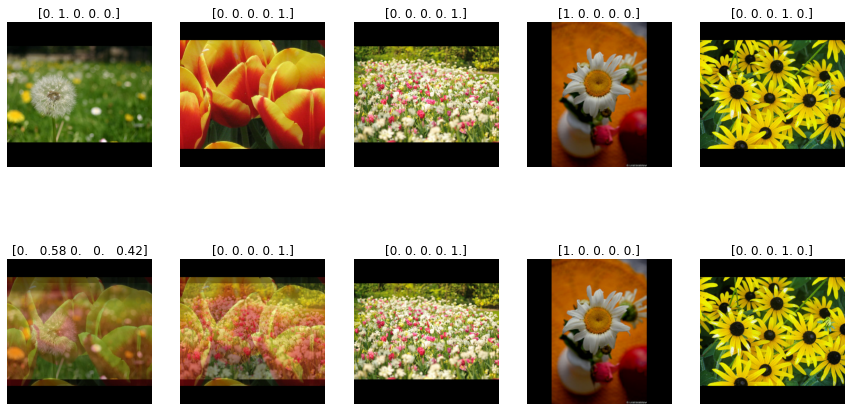

In [12]:
f, ax = plt.subplots(2, 5, figsize=(15,8))
for images, labels in create_preproc_dataset('gs://practical-ml-vision-book/flowers_tfr/train-*').shuffle(200).batch(5).take(1):
    for idx in range(len(images)):
        ax[0, idx].imshow(images[idx].numpy());
        ax[0, idx].set_title('{}'.format(labels[idx].numpy()))
        ax[0, idx].axis('off')
        
    images, labels = augment_mixup(images, labels)
    print(images.shape)
    print(labels.shape)
    for idx in range(len(images)):
        ax[1, idx].imshow(images[idx].numpy());
        ax[1, idx].set_title('{}'.format(labels[idx].numpy()))
        ax[1, idx].axis('off')

最初の40%(`MIXUP_FRAC=0.4`)のみの画像がMixupされていることが確認できました。

## MobileNetによる転移学習  

ランダムなクロッピング+左右の反転+色の拡張+MixUp

In [16]:
import tensorflow_hub as hub
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

#PATTERN_SUFFIX='-0000*'
#NUM_EPOCHS=3

PATTERN_SUFFIX='-*'
NUM_EPOCHS=20

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/train' + PATTERN_SUFFIX
    ).shuffle(8*batch_size).batch(batch_size, drop_remainder=True).map(augment_mixup)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      RandomColorDistortion(name='random_contrast_brightness/none'),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random/center_crop (RandomC  (None, 224, 224, 3)      0         
 rop)                                                            
                                                                 
 random_lr_flip/none (Random  (None, 224, 224, 3)      0         
 Flip)                                                           
                                                                 
 random_contrast_brightness/  (None, 224, 224, 3)      0         
 none (RandomColorDistortion                                     
 )                                                               
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                             

2022-07-11 21:28:09.635422: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 2639, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657574889.635360883","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 2639, Output num: 0","grpc_status":3}


91/91 [==============================] - 29s 304ms/step - loss: 0.8237 - accuracy: 0.7675 - val_loss: 0.5471 - val_accuracy: 0.8238
Epoch 3/20
91/91 [==============================] - 29s 303ms/step - loss: 0.7590 - accuracy: 0.8019 - val_loss: 0.5540 - val_accuracy: 0.8161
Epoch 4/20
91/91 [==============================] - 29s 304ms/step - loss: 0.7311 - accuracy: 0.8094 - val_loss: 0.5107 - val_accuracy: 0.8290
Epoch 5/20
91/91 [==============================] - 30s 304ms/step - loss: 0.7296 - accuracy: 0.8122 - val_loss: 0.4878 - val_accuracy: 0.8446
Epoch 6/20
91/91 [==============================] - 29s 304ms/step - loss: 0.7199 - accuracy: 0.8146 - val_loss: 0.4602 - val_accuracy: 0.8523
Epoch 7/20
91/91 [==============================] - 29s 303ms/step - loss: 0.7111 - accuracy: 0.8197 - val_loss: 0.4597 - val_accuracy: 0.8446
Epoch 8/20
91/91 [==============================] - 29s 304ms/step - loss: 0.7017 - accuracy: 0.8225 - val_loss: 0.4995 - val_accuracy: 0.8135
Epoch 9/20

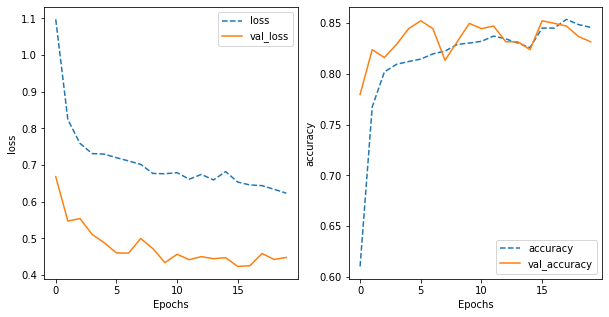

In [17]:
model = train_and_evaluate()

2022-07-11 21:37:54.049230: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 15322, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657575474.049144251","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 15322, Output num: 0","grpc_status":3}


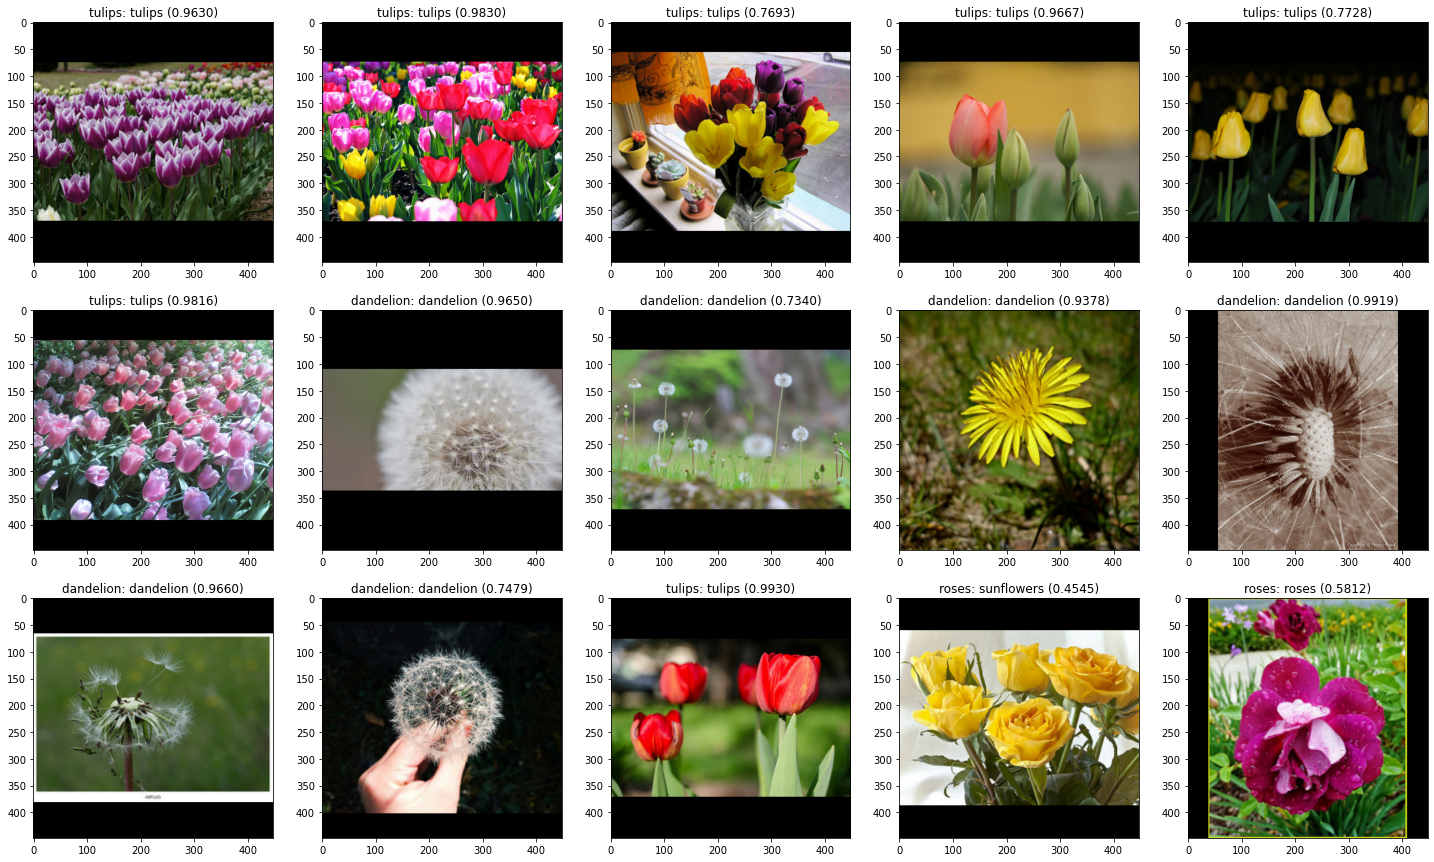

In [18]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[tf.argmax(label).numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book/flowers_tfr/valid-*')

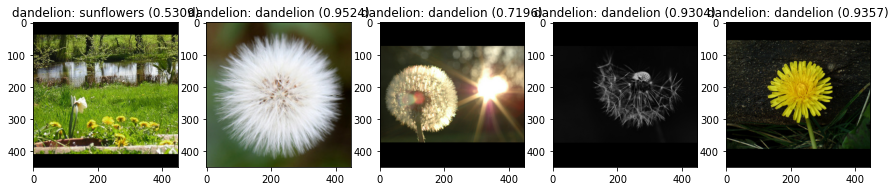

In [19]:
## but actually, for prediction, we won't have TensorFlow Records.
## this is how we'd predict for individual images
## (actually, we'll create a serving function: we'll look at that in a later chapter)
filenames = [
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.